In this case, we will study and test it the mini batch gradient descent in order to take adventage of the parallel computation in the optimization process. Firstly we will study a single thread approach and finally we will implement by means of threads a parallel computation of the algorithm

In [35]:
%matplotlib inline  
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import random

As we see in the before notebook example () we will fit a simple lineal model ($y = mx + b $) to a given data set $D=(x^N,y^N)$ of points where $x,y \in R_2$

In this case we will compute the Gradient for several batchs:

&nbsp;&nbsp;&nbsp;Step 0: $m = \text{random value}, b = \text{random value}$, $bn = \text{value for mini batch size}$

&nbsp;&nbsp;&nbsp;Step 1: $\text{minibatch} = \text{sampling}(D,bn)$

&nbsp;&nbsp;&nbsp;Step 2: $ m = m - (\frac{2}{bn} \sum_{i=1}^{bn} - x_i (y_i - (mx_i+b))) * \alpha  $

&nbsp;&nbsp;&nbsp;Step 3: $ b = b - (\frac{2}{bn} \sum_{i=1}^{bn} - (y_i - (mx_i+b))) * \alpha  $

&nbsp;&nbsp;&nbsp;Step 4: Go to Step 1 (after N iterations)

Therefore **the average of the gradients over this subset (batchs of $bn$ size) is a stochastic gradient.**

Notice that we can compute in a parallel way the mini batch SGD, sampling (in a parallel way) and executing the summatory also with a map reduce function. Check out the Spark implementation to see more:
https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/optimization/GradientDescent.scala#L224

In [36]:
def E(m,b):
    """
    The cost function for our model
    """
    global points
    N = float(len(points))
    error = 0
    for point in points:
        error += (point[0]-(m*point[1] + b)) ** 2
    return error / N

In [37]:
points = np.genfromtxt("data.csv", delimiter=",")
data_X = [p[0] for p in points]
data_Y = [p[1] for p in points]

In [38]:
def step_gradient(m,b,points, alpha = 0.00005):
    """
    Calculate the drop of each parameter in the function (m,b)
    by means of the derivate functions
    """
    N = float(len(points))
    m_descend = 0.0
    b_descend = 0.0
    for point in points:
        m_descend += -(2/N) * point[0]*(point[1]-((m*point[0]) + b))
        b_descend += -(2/N) * (point[1]-((m*point[0]) + b))
    m_descend = m - (m_descend * alpha) 
    b_descend = b - (b_descend * alpha)
    return (m_descend, b_descend)

In [39]:
iterations_number = 100
batch_size = 50
precision = 0.00001
m_old = -2
b_old = 0
    
parameter_its = [(m_old, b_old)]
for iteration in xrange(0, iterations_number):
    B = np.random.randint(10,size=batch_size) # Sampling dataset
    
    m_new,b_new = step_gradient(m_old, b_old, points[B,:])
    parameter_its.append((m_new,b_new))
    if (abs(m_old-m_new)) < precision:
        print("Breaking iterations in (%s it), no more precission achieved" % iteration)
        break
    m_old = m_new
    b_old = b_new
print(m_new, b_new)
E(m_old, b_old)

(1.3729489286580498, 0.066900749248610933)


2868.3435540374858

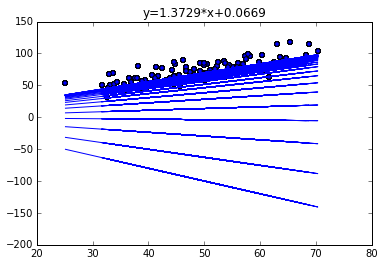

In [40]:
def plot_points_and_modelfit(m,b,toFile=False,iteration=0):
    """
    """
    ablineValues = []
    for x in data_X:
        ablineValues.append(m*x+b)

    plt.scatter(data_X,data_Y)
    plt.plot(data_X, ablineValues, 'b')
    plt.title("y=%s*x+%s" % (round(m_new,4),round(b_new,4)))
    if toFile:
        plt.savefig('/tmp/tmp_%s.png' % iteration, bbox_inches='tight')
    else:
        plt.show()
        
for parameter in parameter_its:
    plot_points_and_modelfit(parameter[0],parameter[1], True)

Finally, we have optimized As you can see the parameters $\theta_2 = \{1.371, 0.0668\}$ with $E(\theta_2) = 2852.9184543990164$